In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [4]:
# import cv
from scipy import spatial

In [5]:
import re
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected, flatten
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.merge_ops import merge
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import random
import sys
from sklearn.model_selection import train_test_split

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


### Defining Constants

In [6]:
SIZE_FACE = 48
EMOTIONS = ['angry', 'disgusted', 'fearful',
            'happy', 'sad', 'surprised', 'neutral']
SAVE_DIRECTORY = '/'
SAVE_MODEL_FILENAME = 'Gudi_model_80_epochs_20000_faces'
DATASET_CSV_FILENAME = 'fer2013.csv'
SAVE_DATASET_IMAGES_FILENAME = 'data_images.npy'
SAVE_DATASET_LABELS_FILENAME = 'data_labels.npy'

In [ ]:
images = np.load("data_images.npy")
images = images.reshape([-1, SIZE_FACE, SIZE_FACE, 1])
labels = np.load("data_labels.npy").reshape([-1, len(EMOTIONS)])

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.22, random_state=42)

In [ ]:
def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b', dtype=tf.float32, initializer=initial)

In [ ]:
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W', dtype=tf.float32, shape=shape, initializer=initer)

In [ ]:
def conv_layer(x, num_filters, filter_size, stride, name):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :return: The output array
    """
    with tf.variable_scope(name):
        num_in_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_in_channel, num_filters]
        W = weight_variable(shape=shape)
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_filters])
        tf.summary.histogram('bias', b)
        layer = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding="SAME")
        layer += b
#         Using non - linearity RELU
        return tf.nn.relu(layer)

In [ ]:
def max_pool(x, ksize, stride, name):
    """
    Create a max pooling layer
    :param x: input to max-pooling layer
    :param ksize: size of the max-pooling filter
    :param stride: stride of the max-pooling filter
    :param name: layer name
    :return: The output array
    """
    return tf.nn.max_pool(x,
                          ksize=[1, ksize, ksize, 1],
                          strides=[1, stride, stride, 1],
                          padding="VALID",
                          name=name)

In [ ]:
def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

In [ ]:
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_out: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(shape=[in_dim, num_units])
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_units])
        tf.summary.histogram('bias', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer


In [ ]:
def dropout(x, keep_prob,name):
    """Create a dropout layer."""
    return tf.nn.dropout(x, keep_prob,name=name)

In [ ]:
def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [ ]:
lr = 0.001  # The optimization initial learning rate
epochs = 20  # Total number of training epochs
batch_size = 50  # Training batch size
display_freq = 50  # Frequency of displaying the training results

In [ ]:
with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, SIZE_FACE, SIZE_FACE, 1], name='X')
    y = tf.placeholder(tf.float32, shape=[None, 7], name='Y')

In [ ]:
conv1 = conv_layer(x, 96, 11,stride=4, name='conv1')
pool1 = max_pool(conv1, 2, stride=2, name='pool1')

conv2 = conv_layer(pool1,256, 11, stride=1,name='conv2')
pool2 = max_pool(conv2, 3, stride=2, name='pool2')


conv3 = conv_layer(pool2, 384, 3, stride=1, name='conv3')

conv4 = conv_layer(conv3, 384, 3, stride=1, name='conv4')

conv5 = conv_layer(conv4, 256, 3, stride=1, name='conv5')
pool5 = max_pool(conv5, 2, stride=2, name='pool5')

layer_flat = flatten_layer(pool5)

fc1 = fc_layer(layer_flat, 4096, name='fc1')
# Using Dropout layer to avoid overfitting
drop1 = dropout(fc1, 0.4,name='drop1')

fc2 = fc_layer(drop1, 4096, name='fc2')
drop2 = dropout(fc2, 0.4, name='drop2')

fc3 = fc_layer(drop2, 1000, name='fc3')
drop3 = dropout(fc3,0.3,name='drop3')

output_logits= fc_layer(fc3, len(EMOTIONS) ,name='OUT', use_relu=False)

In [0]:
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=output_logits), name='loss')
    tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, name='Adam-op').minimize(loss)
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)
    with tf.variable_scope('Prediction'):
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

In [0]:
# Initialize the variables
init = tf.global_variables_initializer()
# Merge all summaries
merged = tf.summary.merge_all()

In [0]:
saver = tf.train.Saver()

In [21]:
lloss = []
aaccc = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
global_step = 0
summary_writer = tf.summary.FileWriter('./logdir', sess.graph)
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch, summary_tr = sess.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_tr, global_step)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: x_valid, y: y_valid}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
    save_path = saver.save(sess, "model.ckpt"+"_"+str(epoch))
    print("Model saved in path: %s" % save_path+'_'+str(epoch))
    lloss.append(loss_valid)
    aaccc.append(acc_valid)

Training epoch: 1
iter   0:	 Loss=1.95,	Training Accuracy=24.0%
iter  50:	 Loss=1.83,	Training Accuracy=22.0%
iter 100:	 Loss=1.89,	Training Accuracy=32.0%
iter 150:	 Loss=1.67,	Training Accuracy=40.0%
iter 200:	 Loss=1.80,	Training Accuracy=26.0%
---------------------------------------------------------
Epoch: 1, validation loss: 1.78, validation accuracy: 29.1%
---------------------------------------------------------
Model saved in path: model.ckpt
Training epoch: 2
iter   0:	 Loss=1.82,	Training Accuracy=26.0%
iter  50:	 Loss=1.81,	Training Accuracy=30.0%
iter 100:	 Loss=1.70,	Training Accuracy=26.0%
iter 150:	 Loss=1.68,	Training Accuracy=30.0%
iter 200:	 Loss=1.53,	Training Accuracy=32.0%
---------------------------------------------------------
Epoch: 2, validation loss: 1.62, validation accuracy: 37.9%
---------------------------------------------------------
Model saved in path: model.ckpt
Training epoch: 3
iter   0:	 Loss=1.56,	Training Accuracy=38.0%
iter  50:	 Loss=1.80,	Tr

### Visualizing the accuracy and loss of model for facial expression recognition

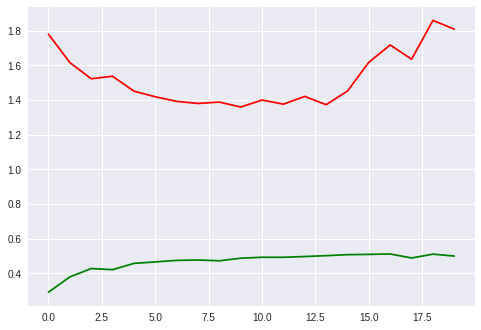

In [25]:
plt.plot([n for n in range(epoch+1)],lloss,'-r')
plt.plot([n for n in range(epoch+1)],aaccc,'-g')

### Calculating the distance between the accuracy and loss of model

In [28]:
lloss_coords = list(zip([n for n in range(epoch+1)],lloss))
aaccc_coords = list(zip([n for n in range(epoch+1)],aaccc))
print(lloss_coords,aaccc_coords)

[(0, 1.779267), (1, 1.6156559), (2, 1.5225643), (3, 1.5367703), (4, 1.45082), (5, 1.4184774), (6, 1.3919834), (7, 1.380047), (8, 1.3878713), (9, 1.3592423), (10, 1.3995298), (11, 1.3758839), (12, 1.4206543), (13, 1.3726779), (14, 1.4517642), (15, 1.6177143), (16, 1.717247), (17, 1.6351981), (18, 1.8589615), (19, 1.8085783)] [(0, 0.29118028), (1, 0.37937742), (2, 0.4276913), (3, 0.42120624), (4, 0.4575227), (5, 0.46595332), (6, 0.47470817), (7, 0.47697794), (8, 0.4724384), (9, 0.4873541), (10, 0.4928664), (11, 0.49254215), (12, 0.49708173), (13, 0.5019455), (14, 0.5077821), (15, 0.50940335), (16, 0.51167315), (17, 0.4886511), (18, 0.5107004), (19, 0.49967575)]


In [0]:
dist = []
for i in range(len(lloss_coords)):
    dis = spatial.distance.euclidean(lloss_coords[i],aaccc_coords[i])
    dist.append(dis)

### Visualizing the point  where distance between accuracy and loss of model is minimum

Text(0.5, 1.0, 'distance between the accuracy and loss')

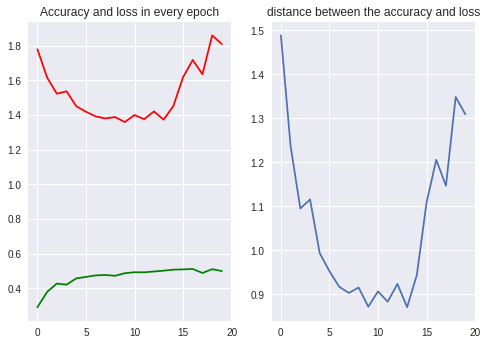

In [36]:
ax1 = plt.subplot(121)
plt.plot([n for n in range(epoch+1)],lloss,'-r')
plt.plot([n for n in range(epoch+1)],aaccc,'-g')
ax1.set_title('Accuracy and loss in every epoch')
ax2 = plt.subplot(122)
plt.plot([n for n in range(epoch+1)],dist)
ax2.set_title('distance between the accuracy and loss')

In [48]:
def sortsecond(x):
    return x[1]

enm = list(enumerate(dist))
print(enm)
print(sorted(enm, key=sortsecond)[0])

[(0, 1.4880866706371307), (1, 1.236278474330902), (2, 1.0948729813098907), (3, 1.1155641078948975), (4, 0.993297278881073), (5, 0.9525240957736969), (6, 0.9172752201557159), (7, 0.903069019317627), (8, 0.915432870388031), (9, 0.8718882203102112), (10, 0.9066634178161621), (11, 0.8833417892456055), (12, 0.9235725700855255), (13, 0.8707324266433716), (14, 0.9439821243286133), (15, 1.1083109378814697), (16, 1.205573856830597), (17, 1.146547019481659), (18, 1.3482610583305359), (19, 1.3089025020599365)]
(13, 0.8707324266433716)


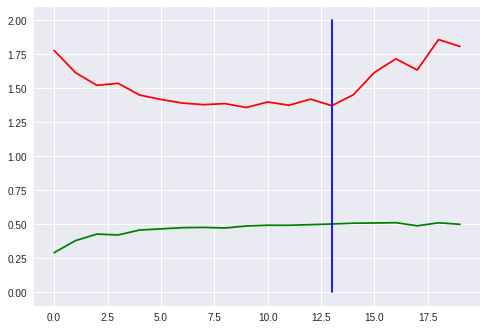

In [51]:
plt.plot([n for n in range(epoch+1)],lloss,'-r')
plt.plot([n for n in range(epoch+1)],aaccc,'-g')
plt.plot([13 for n in range(epoch+1)],[i for i in np.linspace(0,2,epoch+1)],'-b')

### Finally Model is best trained when epoch was 13. So, using model weights at epoch 13 to predict facial expression.
### But still accuracy is 53%, We can check accuracy with different model like VGG16 , VGG19, ResNet, InceptionV3 and can use that module give best accuracy and lowest  loss.

### Since models like VGG16 , VGG19, ResNet, InceptionV3 is big which will take much more time than AlexNet so due to some constraints like Complexity and Time I use AlexNet.